<a href="https://www.kaggle.com/code/dendyandra/mnist-digit-recognition?scriptVersionId=134440300" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load Dataset

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


# Simple EDA

## Label Distribution

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Split Data
X = train.drop('label',axis=1)
y = train[['label']]

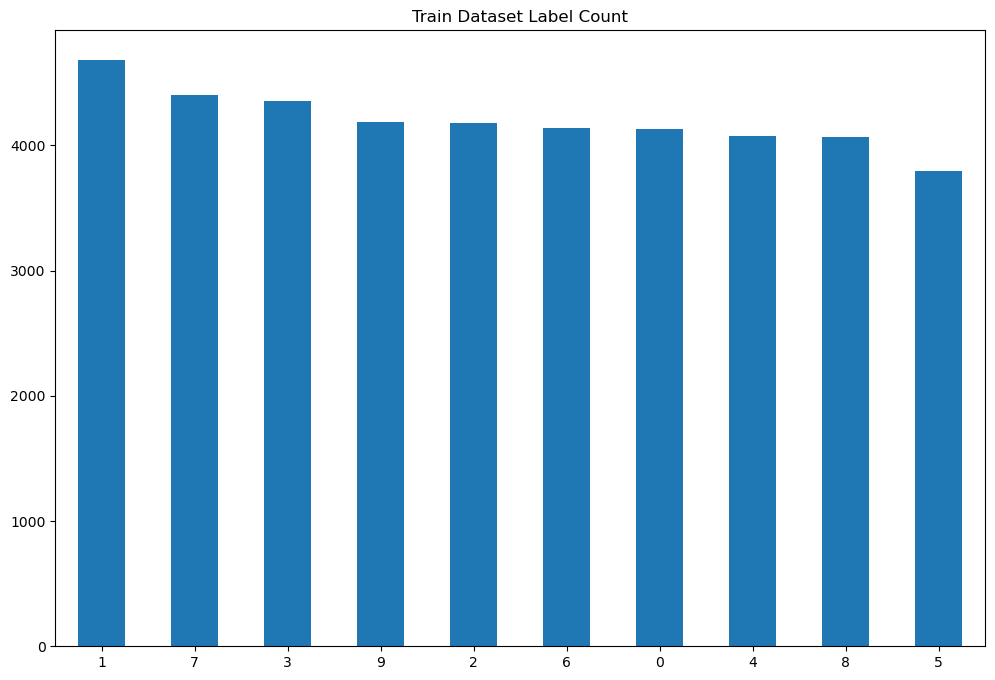

In [5]:
f, ax = plt.subplots(1,1, figsize=(12,8))
y.label.value_counts().plot(kind='bar', rot=0, ax=ax)
ax.set_title('Train Dataset Label Count')
# test.label.value_counts().plot(kind='bar', rot=0, ax=ax[1])
# ax[1].set_title('Test Dataset Label Count')
plt.show()

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 251.2 MB


In [7]:
import random

## Reshape Data to 28x28
Because in dataset we have 784 pixel, so the image will be 28x28

In [8]:
X = X.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28,1)

## Visualize Image Data

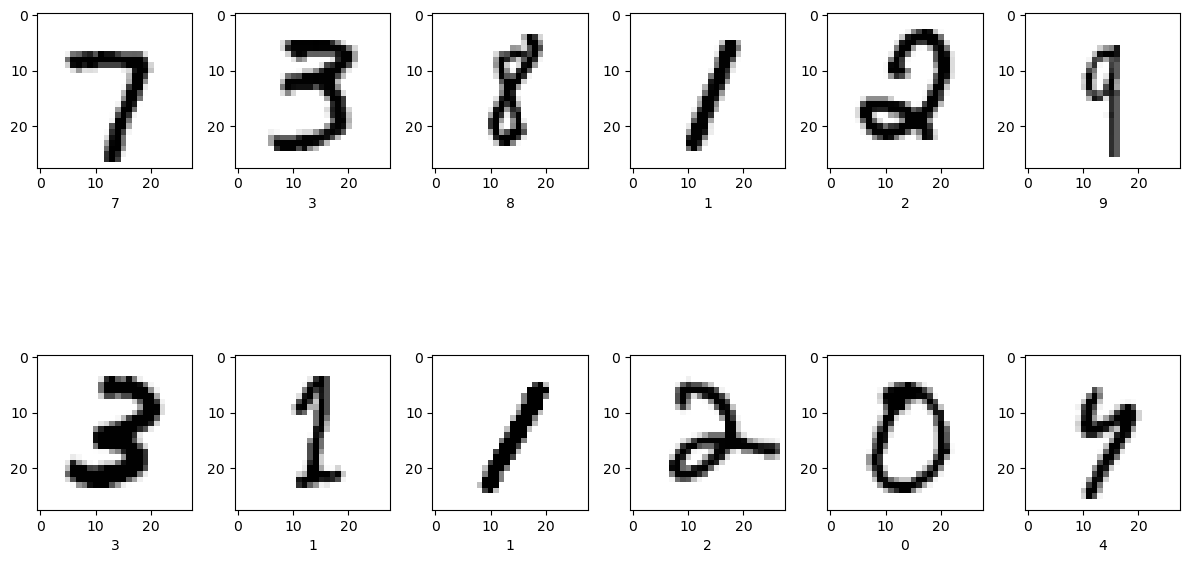

In [9]:
# Visualize some images
f,ax = plt.subplots(2, 6, figsize=(12,8))
for i in range(6):
    idx = random.randrange(len(X))
    ax[0][i].imshow(X[idx], cmap='binary')
    ax[0][i].set_xlabel(y.iloc[idx].values[0])
    ax[1][i].imshow(X[idx+5], cmap='binary')
    ax[1][i].set_xlabel(y.iloc[idx+5].values[0])
plt.tight_layout() 
plt.show()

# Preprocessing

## Train - Val Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=.2, random_state=1 )
print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)
print("X_val shape",X_val.shape)
print("y_val shape",y_val.shape)

X_train shape (33600, 28, 28, 1)
y_train shape (33600, 1)
X_val shape (8400, 28, 28, 1)
y_val shape (8400, 1)


## Rescale Image

In [12]:
X_train = X_train / 255
X_val = X_val / 255
X_test = test / 255

## Convert Image Label to Binary Matrix

In [13]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [14]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [15]:
# Train data shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 28, 28, 1) (33600, 10)
(8400, 28, 28, 1) (8400, 10)


## Image Augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
datagenerator = ImageDataGenerator(horizontal_flip=False,
                                   vertical_flip=False,
                                   shear_range=0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=10)

# X_train2 = train_datagenerator.flow(x=X_train, y=y_train, batch_size=32)
datagenerator.fit(X_train)
# X_test2 = train_datagenerator.flow(x=X_test, batch_size=32)

# CNN Model Training

In [18]:
X_train.shape

(33600, 28, 28, 1)

In [19]:
input_shape = (28, 28, 1)
n_output = y_train.shape[1]
model = tf.keras.Sequential([
    # 1st Conv layer
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    # 2nd Conv layer
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    # 3nd Conv layer
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    
    # Classifier Head
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_output, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

In [20]:
# Define early stopping and LR reduction on training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

## Model Training

In [21]:
# X_val.shape

In [22]:
# history = model.fit(X_train2, epochs=50, batch_size=32, callbacks=[es])
history = model.fit(datagenerator.flow(X_train, y_train, batch_size=32), 
                              validation_data=(X_val,y_val),
                              epochs=50,  
                              callbacks=[es, lr_reduction])

Epoch 1/50


2023-06-22 04:34:47.532762: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1050/1050 [==============================] - 24s 15ms/step - loss: 0.6621 - accuracy: 0.7821 - val_loss: 0.0911 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 15s 14ms/step - loss: 0.2332 - accuracy: 0.9303 - val_loss: 0.0677 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 15s 15ms/step - loss: 0.1634 - accuracy: 0.9501 - val_loss: 0.0508 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 15s 14ms/step - loss: 0.1381 - accuracy: 0.9569 - val_loss: 0.0496 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 5/50
1050/1050 [==============================] - 15s 15ms/step - loss: 0.1200 - accuracy: 0.9635 - val_loss: 0.0486 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 6/50
1050/1050 [==============================] - 15s 14ms/step - loss: 0.1087 - accuracy: 0.9673 - val_loss: 0.0431 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 7/50
1050/1050 [==============================] - 1

# Model Evaluation

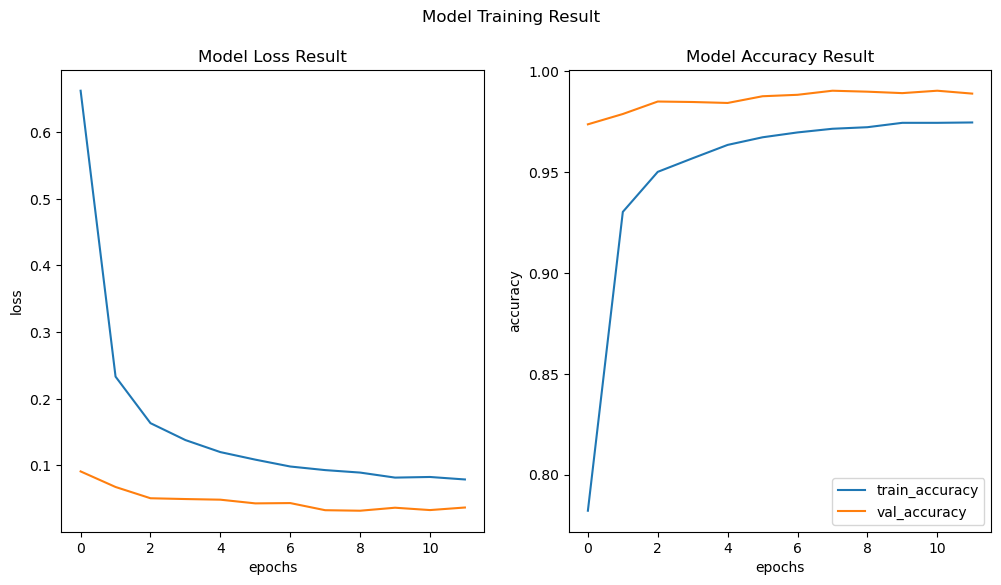

In [23]:
f, ax = plt.subplots(1,2, figsize=(12,6))
f.suptitle('Model Training Result')
ax[0].plot(history.history['loss'], label='train_loss',)
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('Model Loss Result')

ax[1].plot(history.history['accuracy'], label='train_accuracy',)
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Model Accuracy Result')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(X_test)

875/875 [==============================] - 2s 2ms/step


In [25]:
test_preds = []
for i in range(len(y_pred)):
    test_preds.append(np.argmax(y_pred[i]))

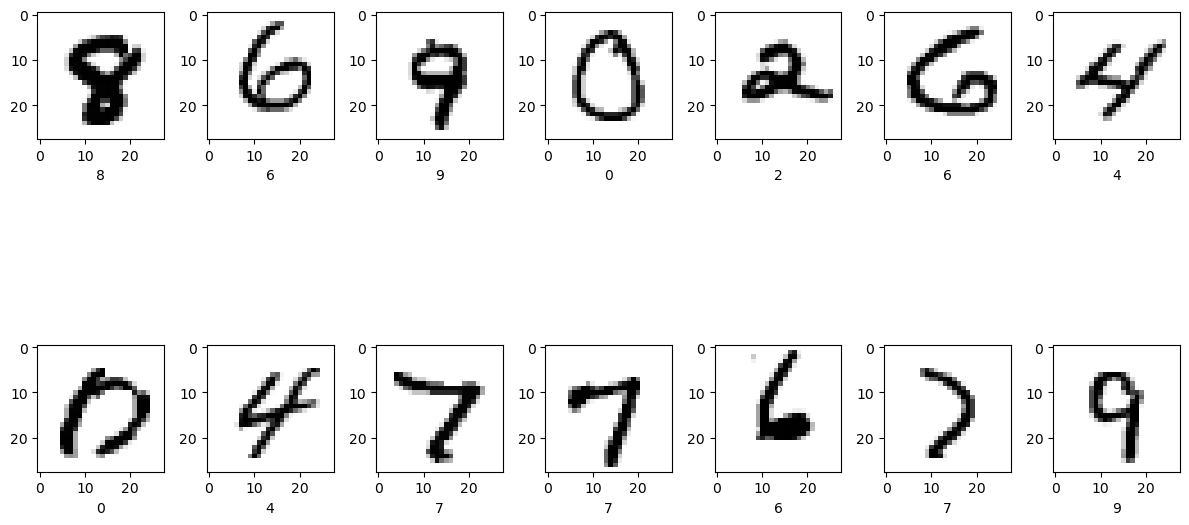

In [26]:
# Test Visualization Result
f,ax = plt.subplots(2, 7, figsize=(12,8))
for i in range(7):
    idx = random.randrange(len(X_test))
    ax[0][i].imshow(X_test[idx], cmap='binary')
    ax[0][i].set_xlabel(test_preds[idx])
    ax[1][i].imshow(X_test[idx+5], cmap='binary')
    ax[1][i].set_xlabel(test_preds[idx+5])
plt.tight_layout()
plt.show()

# Submission

In [27]:
submission = pd.DataFrame({'ImageId': range(1, len(test_preds) + 1), 'Label': test_preds})

In [28]:
# Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)